# Task 1: Advanced Exploratory Data Analysis (EDA) & Feature Engineering

In [1]:
# ----------------------------------------------
# Importing Libraries
# ----------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/panchaldhruv27223/datasets_for_ml_-csv-xlsl-/refs/heads/main/kc_house_data.csv ')

In [3]:
df_shape = df.shape
df_shape

(21613, 21)

In [4]:
cols_to_nan = ['sqft_lot', 'bathrooms']
frac = 0.05
rng = np.random.default_rng(42)
df_missing = df.copy()
for col in cols_to_nan:
    n = len(df_missing)
    idx = rng.choice(n, size=int(frac*n), replace=False)
    df_missing.loc[df_missing.index[idx], col] = np.nan

print('Missing values per column:')
print(df_missing[cols_to_nan].isna().sum())

Missing values per column:
sqft_lot     1080
bathrooms    1080
dtype: int64


In [5]:
# ----------------------------------------------
# Data Cleaning
# ----------------------------------------------

In [6]:
# median_imputer = SimpleImputer(strategy='median')
# mode_imputer = SimpleImputer(strategy='most_frequent')

# '''sqft_lot ->  Median is more robust to outlier than mean for this type of data.
#    Bathrooms -> Mode is best for this type of data
# '''

In [7]:
# df['sqft_lot'] = median_imputer.fit_transform(df[['sqft_lot']])
# df['bathrooms'] = mode_imputer.fit_transform(df[['bathrooms']])

### 1. Outlier Detection and Handling:

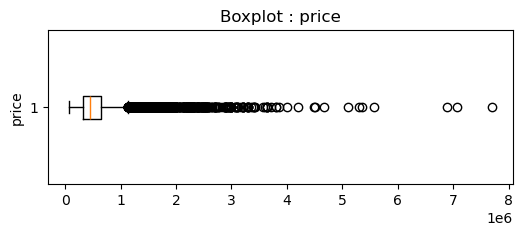

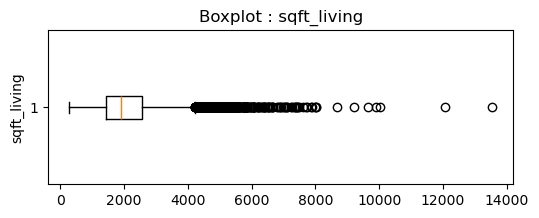

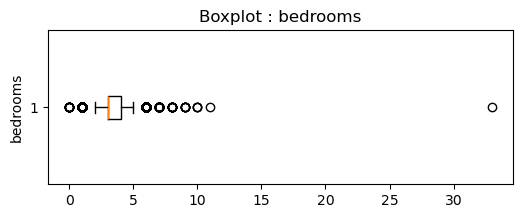

In [8]:
for col in ['price', 'sqft_living', 'bedrooms']:
    plt.figure(figsize=(6,2))
    plt.boxplot(df_missing[col].dropna().values, vert = False,  showfliers=True)
    plt.title(f'Boxplot : {col}')
    plt.ylabel(col)

price: lower=-162625.00, upper=1129575.00, outliers=1146
sqft_living: lower=-257.50, upper=4234.50, outliers=572
bedrooms: lower=1.50, upper=5.50, outliers=546

Original shape: (21613, 21)
After outlier removal: (19825, 21)


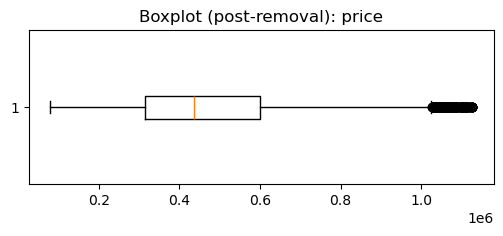

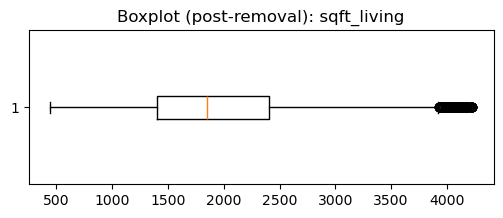

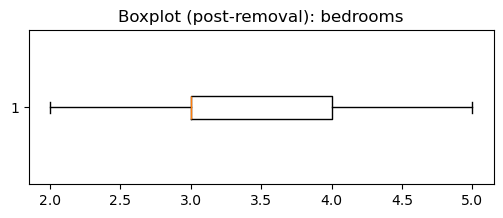

In [11]:
outlier_cols = ['price', 'sqft_living', 'bedrooms']
masks = {}
bounds = {}
for c in outlier_cols:
    q1 = df_missing[c].quantile(0.25)
    q3 = df_missing[c].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (df_missing[c] < lower) | (df_missing[c] > upper)
    masks[c] = mask
    bounds[c] = (lower, upper)
    print(f"{c}: lower={lower:.2f}, upper={upper:.2f}, outliers={mask.sum()}")

combined_outliers = np.zeros(len(df_missing), dtype=bool)
for c in outlier_cols:
    combined_outliers = combined_outliers | masks[c]

df_clean = df_missing.loc[~combined_outliers].copy()
print('\nOriginal shape:', df_missing.shape)
print('After outlier removal:', df_clean.shape)

# Save post-removal boxplots
for col in outlier_cols:
    plt.figure(figsize=(6,2))
    plt.boxplot(df_clean[col].dropna().values, vert=False, showfliers=True)
    plt.title(f'Boxplot (post-removal): {col}')

In [12]:
df_fe = df_clean.copy()

In [13]:
df_fe['date'] = pd.to_datetime(df_fe['date'], errors='coerce')
df_fe['sale_year'] = df_fe['date'].dt.year
df_fe['sale_month'] = df_fe['date'].dt.month
df_fe['house_age'] = df_fe['sale_year'] - df_fe['yr_built']

In [14]:
df_fe['was_renovated'] = (df_fe['yr_renovated'].fillna(0) != 0).astype(int)
df_fe['age_since_renovation'] = np.where(
    df_fe['yr_renovated'].fillna(0) == 0,
    df_fe['house_age'],
    df_fe['sale_year'] - df_fe['yr_renovated']
)

In [15]:
df_fe['floors_safe'] = df_fe['floors'].replace(0, 1)
df_fe['bedrooms_safe'] = df_fe['bedrooms'].replace(0, 1)
df_fe['sqft_living_per_floor'] = df_fe['sqft_living'] / df_fe['floors_safe']
df_fe['bath_per_bed'] = df_fe['bathrooms'] / df_fe['bedrooms_safe']

In [16]:
df_fe.drop(columns=['floors_safe', 'bedrooms_safe'], inplace=True)

print('After feature engineering shape are ', df_fe.shape)
df_fe.head()

After feature engineering shape are  (19825, 28)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,sale_year,sale_month,house_age,was_renovated,age_since_renovation,sqft_living_per_floor,bath_per_bed
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650.0,1.0,0,0,...,-122.257,1340,5650,2014,10,59,0,59,1180.0,0.333333
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242.0,2.0,0,0,...,-122.319,1690,7639,2014,12,63,1,23,1285.0,0.750000
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000.0,1.0,0,0,...,-122.233,2720,8062,2015,2,82,0,82,770.0,0.500000
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000.0,1.0,0,0,...,-122.393,1360,5000,2014,12,49,0,49,1960.0,0.750000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080.0,1.0,0,0,...,-122.045,1800,7503,2015,2,28,0,28,1680.0,0.666667


In [17]:
final_df = df_fe.copy()

In [18]:
final_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,sale_year,sale_month,house_age,was_renovated,age_since_renovation,sqft_living_per_floor,bath_per_bed
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650.0,1.0,0,0,...,-122.257,1340,5650,2014,10,59,0,59,1180.0,0.333333
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242.0,2.0,0,0,...,-122.319,1690,7639,2014,12,63,1,23,1285.0,0.750000
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000.0,1.0,0,0,...,-122.233,2720,8062,2015,2,82,0,82,770.0,0.500000
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000.0,1.0,0,0,...,-122.393,1360,5000,2014,12,49,0,49,1960.0,0.750000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080.0,1.0,0,0,...,-122.045,1800,7503,2015,2,28,0,28,1680.0,0.666667


In [19]:
final_df.isna().sum()

id                         0
date                       0
price                      0
bedrooms                   0
bathrooms                979
sqft_living                0
sqft_lot                 980
floors                     0
waterfront                 0
view                       0
condition                  0
grade                      0
sqft_above                 0
sqft_basement              0
yr_built                   0
yr_renovated               0
zipcode                    0
lat                        0
long                       0
sqft_living15              0
sqft_lot15                 0
sale_year                  0
sale_month                 0
house_age                  0
was_renovated              0
age_since_renovation       0
sqft_living_per_floor      0
bath_per_bed             979
dtype: int64

In [20]:
X = final_df.drop(columns=['price'])
y = final_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15860, 27), (3965, 27), (15860,), (3965,))

# Task 2: Build a Sophisticated Preprocessing Pipeline

### 1. Identify Feature Types: After your feature engineering in Task 1, categorize your final columns into three groups:
##### ○ Numerical Features: Continuous variables that need imputation and scaling (e.g., sqft_living, house_age, sqft_lot).
##### ○ Categorical Features: Features that should be treated as categories, not numbers (e.g., zipcode).
##### ○ Passthrough Features: Features you believe don't need scaling or encoding but are still useful (e.g., grade, condition, was_renovated).

In [22]:
numeric_features = [
    'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
    'lat', 'long', 'sqft_living15', 'sqft_lot15',
    'house_age', 'age_since_renovation',
    'sqft_living_per_floor', 'bath_per_bed',
    'bedrooms', 'bathrooms', 'floors', 'view'
]

In [23]:
categorical_features = ['zipcode']

In [24]:
passthrough_features = ['grade', 'condition', 'was_renovated', 'sale_year', 'sale_month', 'waterfront']

In [25]:
existing = set(X_train.columns)
numeric_features = [c for c in numeric_features if c in existing]
categorical_features = [c for c in categorical_features if c in existing]
passthrough_features = [c for c in passthrough_features if c in existing]

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)
print('Passthrough features:', passthrough_features)

Numeric features: ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'house_age', 'age_since_renovation', 'sqft_living_per_floor', 'bath_per_bed', 'bedrooms', 'bathrooms', 'floors', 'view']
Categorical features: ['zipcode']
Passthrough features: ['grade', 'condition', 'was_renovated', 'sale_year', 'sale_month', 'waterfront']


### 2. Create Preprocessing Pipelines for Each Type:

##### ○ Numerical Pipeline: Create a Pipeline that first imputes missing values (using SimpleImputer with a median strategy) and then scales the data (using StandardScaler).
##### ○ Categorical Pipeline: Create a Pipeline that applies OneHotEncoder to the zipcode column. Set handle_unknown='ignore' to prevent errors if the test set contains a zipcode not seen in the training set.

In [26]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### 3. Combine Pipelines with ColumnTransformer:
##### ○ Use ColumnTransformer to apply your numerical pipeline to the numerical columns, your categorical pipeline to the categorical columns, and specify 'passthrough' for the passthrough columns.
##### ○ This ColumnTransformer will be the first step in your final modeling pipeline.

In [27]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features),
    ('pass', 'passthrough', passthrough_features)
])

# Task 3 :- Model Training and Hyperparameter Tuning

In [28]:
'''
Testing Pipeline for Basic Linear Regression
'''

'\nTesting Pipeline for Basic Linear Regression\n'

In [29]:
test_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ('regressor', LinearRegression())
])

test_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sqft_living', 'sqft_lot',
                                                   'sqft_above',
                                                   'sqft_basement', 'lat',
                                                   'long', 'sqft_living15',
                                                   'sqft_lot15', 'house_age',
                                                   'age_since_renovation',
                                                   'sqft_living_per_floor',
                                                   'bath_per_bed', 'bedrooms',
                                                   'bathrooms', 'floors',
                                                   'view']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['zipcode']),
                                                 ('pass', 'passthrough',
                                                  ['grade', 'condition',
                                                   'was_renovated', 'sale_year',
                                                   'sale_month',
                                                   'waterfront'])])),
                ('regressor', LinearRegression())])

In [30]:
test_pred = test_pipe.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Linear Regression RMSE:-", test_rmse)

Test Linear Regression RMSE:- 81852.80226722616


##### Now, find the best possible model by tuning its hyperparameters.
##### 1. Select Candidate Models: Based on the results from the original notebook, choose the top 3 performing models (e.g., Gradient Boosting, XGBoost, Random Forest).
##### Create a Final Pipeline: For each of the three models, create a main Pipeline that chains your ColumnTransformer (from Task 2) and the model estimator.

##### 2. Hyperparameter Tuning with GridSearchCV:
##### ○ For each of your three final pipelines, define a parameter grid (param_grid) to search. For the regressor step, remember to prefix the parameter names with regressor__ (e.g., 'regressor__n_estimators': [100, 200]).
##### ○ Choose at least two parameters to tune for each model.
##### ○ Use GridSearchCV with 3 fold cross-validation (cv=3) to find the best set of hyperparameters for each model.
##### ○ Train GridSearchCV on the full training data. It will automatically handle applying the preprocessing pipeline correctly during cross-validation.

In [31]:
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

grids = {
    'RandomForest': {
        'regressor__n_estimators': [200, 400],
        'regressor__max_depth': [None, 20]
    },
    'GradientBoosting': {
        'regressor__n_estimators': [200, 400],
        'regressor__learning_rate': [0.05, 0.1]
    },
    'XGBoost': {
        'regressor__max_depth': [3, 6, 10],
        'regressor__learning_rate': [0.05, 0.1]
    }
}

results = []
best_overall = None
best_overall_name = None
best_overall_rmse_cv = np.inf
best_overall_estimator = None

for name, est in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', est)])
    param_grid = grids[name]
    print('\nRunning GridSearch for', name)
    gscv = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
    gscv.fit(X_train, y_train)
    best_cv_rmse = -gscv.best_score_
    y_pred = gscv.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({
        'model': name,
        'best_params': gscv.best_params_,
        'cv_rmse': best_cv_rmse,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse
    })
    print(f"{name} done. CV RMSE: {best_cv_rmse:.2f} | Test RMSE: {test_rmse:.2f}")
    if best_cv_rmse < best_overall_rmse_cv:
        best_overall_rmse_cv = best_cv_rmse
        best_overall = gscv
        best_overall_name = name
        best_overall_estimator = gscv.best_estimator_

results = pd.DataFrame(results).sort_values('test_rmse')
results.to_csv(f"model_results.csv", index=False)
results


Running GridSearch for RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits
RandomForest done. CV RMSE: 77306.42 | Test RMSE: 75945.88

Running GridSearch for GradientBoosting
Fitting 3 folds for each of 4 candidates, totalling 12 fits
GradientBoosting done. CV RMSE: 73733.98 | Test RMSE: 71903.76

Running GridSearch for XGBoost
Fitting 3 folds for each of 6 candidates, totalling 18 fits
XGBoost done. CV RMSE: 73382.35 | Test RMSE: 72251.97


,model,best_params,cv_rmse,test_r2,test_mae,test_rmse
1,GradientBoosting,"{'regressor__learning_rate': 0.1, 'regressor__...",73733.977752,0.874856,50085.245961,71903.755494
2,XGBoost,"{'regressor__learning_rate': 0.1, 'regressor__...",73382.350731,0.873641,49672.201894,72251.967620
0,RandomForest,"{'regressor__max_depth': None, 'regressor__n_e...",77306.423533,0.860390,51539.790269,75945.882891


# Task 4: Evaluation and Interpretation

### Finally, evaluate your best model and interpret its results.

##### 1. Final Evaluation:
##### ○ Identify the best overall model and its parameters from your GridSearchCV results.
##### ○ Evaluate this best tuned pipeline on the test set.
#####  Report the final R2 score, Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE).

In [32]:
print('Best model (by CV RMSE):', best_overall_name)
best = best_overall
best_pipe = best_overall_estimator
y_best = best.predict(X_test)
final_r2 = r2_score(y_test, y_best)
final_mae = mean_absolute_error(y_test, y_best)
final_rmse = np.sqrt(mean_squared_error(y_test, y_best))
print(f"Test R2: {final_r2:.4f}")
print(f"Test MAE: {final_mae:,.2f}")
print(f"Test RMSE: {final_rmse:,.2f}")

Best model (by CV RMSE): XGBoost
Test R2: 0.8736
Test MAE: 49,672.20
Test RMSE: 72,251.97


##### 2. Performance Comparison:
##### ○ Create a table or bar chart comparing the RMSE of your final, tuned model to the RMSE of the best model from the original notebook.
##### ○ Calculate and report the percentage improvement in RMSE.

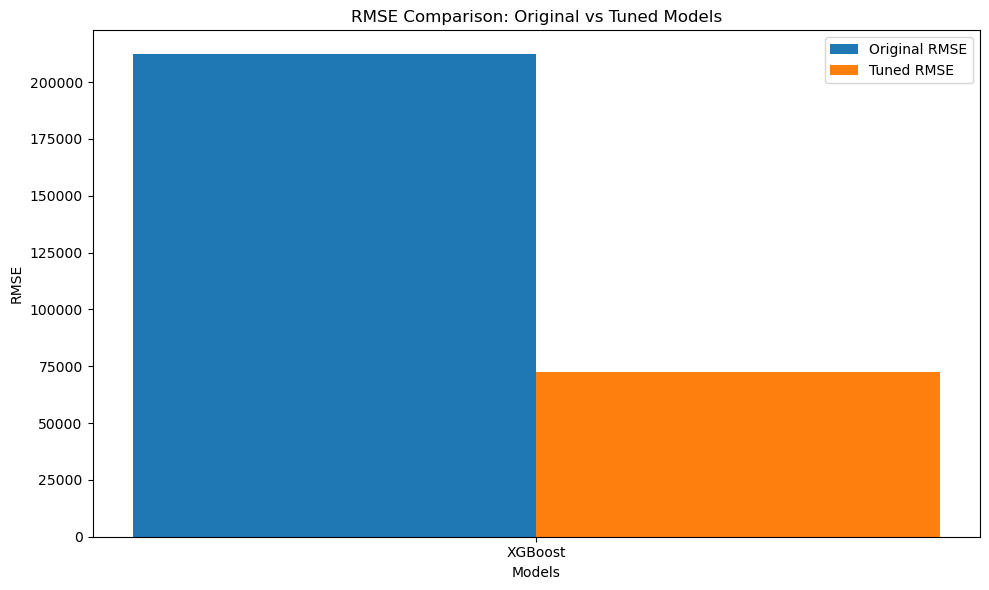

In [34]:
original_results = pd.read_csv('Original_Notebook_Results.csv')
best_models_results = pd.read_csv('model_results.csv')

original_results_renamed = original_results.rename(columns={"Model": "Model", "RMSE": "RMSE_original"})
best_models_results_renamed = best_models_results.rename(columns={"model": "Model", "test_rmse": "RMSE_tuned"})

comparison_df = pd.merge(original_results_renamed[['Model', 'RMSE_original']], 
                         best_models_results_renamed[['Model', 'RMSE_tuned']], 
                         on='Model', 
                         how='inner')

comparison_df['RMSE_Improvement_%'] = 100 * (comparison_df['RMSE_original'] - comparison_df['RMSE_tuned']) / comparison_df['RMSE_original']

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(comparison_df))

plt.bar(index, comparison_df['RMSE_original'], bar_width, label='Original RMSE')
plt.bar([i + bar_width for i in index], comparison_df['RMSE_tuned'], bar_width, label='Tuned RMSE')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison: Original vs Tuned Models')
plt.xticks([i + bar_width/2 for i in index], comparison_df['Model'])
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
comparison_df.head()

,Model,RMSE_original,RMSE_tuned,RMSE_Improvement_%
0,XGBoost,212131.231023,72251.96762,65.939967


In [41]:
comparison_df.to_csv("Report.csv",index=False)

##### 3. Feature Importance:
##### ○ If your best model was a tree based model (like RandomForest or XGBoost), extract and plot the feature importances.
##### ○ Important: The feature names from the OneHotEncoder will be generic. You'll need to retrieve the original categorical feature names to make your plot interpretable.

##### ○ Write a brief summary analyzing the top 5 most important features.Do they make sense? Are any of your engineered features in the top 5?

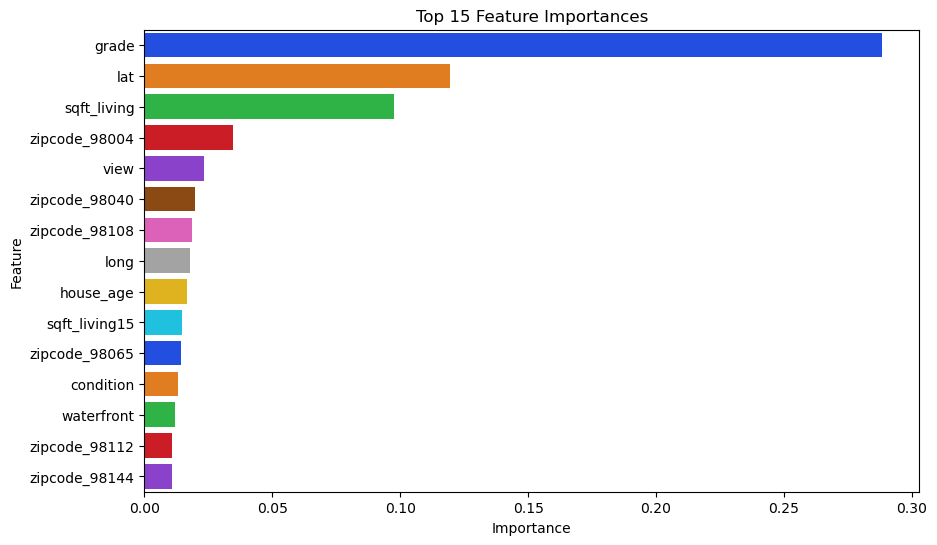

Top 5 Important Features:
          Feature  Importance
86          grade    0.288423
4             lat    0.119659
0     sqft_living    0.097763
19  zipcode_98004    0.034604
15           view    0.023408


In [43]:
import warnings
warnings.filterwarnings('ignore')

pipe = gscv.best_estimator_

ohe = pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe']
cat_features = pipe.named_steps['preprocessor'].transformers_[1][2]
ohe_features = list(ohe.get_feature_names_out(cat_features))

num_features = pipe.named_steps['preprocessor'].transformers_[0][2]
passthrough_features = pipe.named_steps['preprocessor'].transformers_[2][2]
all_features = num_features + ohe_features + passthrough_features

importances = pipe.named_steps['regressor'].feature_importances_
feature_importances = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='bright')
plt.title("Top 15 Feature Importances")
plt.show()

print("Top 5 Important Features:")
print(feature_importances.head(5))

In [40]:
'''
Top 5 Most Important Features :- Grade, Latitude, Living Area, Zipcode, View

1. Grade (grade):-
    It Shows How good house construction and quality.
    Higher Grades indicates better materials which increase house price.
    its near about make good impact on model.

2. Latitude (lat):-
    Latitude of House also reflects the geographic location which show if the location is nearest to rich area may increases house price. 
    if the location is nearest to slum area may decreases house price.
    So Latitude also make good impact on model

3. Living Area (sqft_living):-
    Represents Larger Living space directly increases property value, so its highly important.

4. Zipcode :-
    Zipcode corresponds to area, makes high important on model.

5. View :-
    Properties with better view typically refers to a premium house.
    it is also most important feature.
'''

'\nTop 5 Most Important Features :- Grade, Latitude, Living Area, Zipcode, View\n\n1. Grade (grade):-\n    It Shows How good house construction and quality.\n    Higher Grades indicates better materials which increase house price.\n    its near about make good impact on model.\n\n2. Latitude (lat):-\n    Latitude of House also reflects the geographic location which show if the location is nearest to rich area may increases house price. \n    if the location is nearest to slum area may decreases house price.\n    So Latitude also make good impact on model\n\n3. Living Area (sqft_living):-\n    Represents Larger Living space directly increases property value, so its highly important.\n\n4. Zipcode :-\n    Zipcode corresponds to area, makes high important on model.\n\n5. View :-\n    Properties with better view typically refers to a premium house.\n    it is also most important feature.\n'